In [16]:
import sys
import os
import logging
sys.path.insert(1, os.path.join(sys.path[0], '../../src'))
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts import concatenate
from datasets import PaloAltoDataset, WeatherEcadDataset, ShellDataset
from visualization import plot_time_series_predictions
from eval import evaluate, print_metrics_table
### Load Dataset
dataset = ShellDataset()
data = dataset.load(subset=9, split=0.3, chunk_length=365, min_chunk_length=365, na_threshold=0.1, select_last_only=True)

Loaded 9 time series each with lengths [365, 365, 365, 365, 365, 365, 365, 365, 365]


In [17]:
data['train'] = data['train'][7:]
data['test'] = data['test'][7:]
# Transform splits
target_scaler = Scaler(MinMaxScaler())
train_series = target_scaler.fit_transform(data['train'])
test_series = target_scaler.transform(data['test'])

# Load Covariates
weather_dataset = WeatherEcadDataset()
past_covariates = weather_dataset.load_covariates()

# Scale Covariates
covariates_scaler = Scaler(MinMaxScaler())
past_covariates = covariates_scaler.fit_transform(past_covariates)
print("Number of data points in train, test: ", len(data['train'][0]),  len(data['test'][0]))

Number of data points in train, test:  110 255


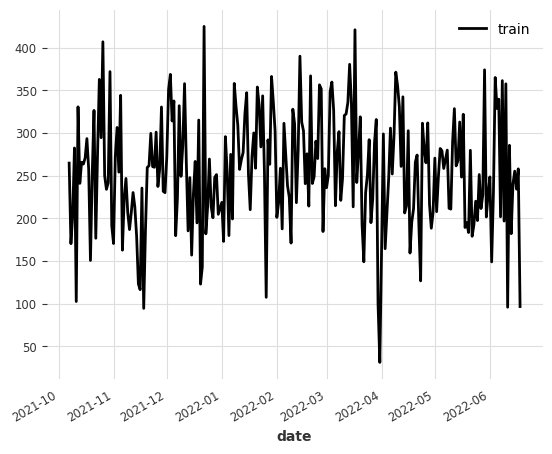

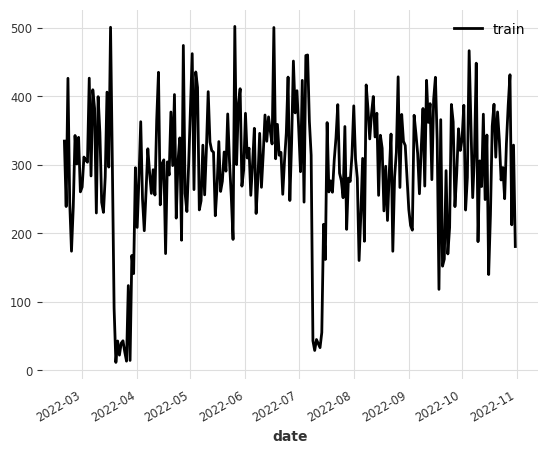

In [18]:
import matplotlib.pyplot as plt
for series in data['test']:
    series.plot(label='train')
    plt.show()

In [19]:
from darts.models import NHiTSModel

In [27]:
# Load pretrained model
model = NHiTSModel.load("../../models/nhits_model_shell_4.pt")

## Zero-Shot Generalisation

In [21]:
predictions = []
for train_series_single, test_series_single in zip(train_series, test_series):
    forecast = model.historical_forecasts(
        series=concatenate([train_series_single, test_series_single]),
        past_covariates=past_covariates,
        start=test_series_single.start_time(),
        forecast_horizon=1,
        retrain=False
    )
    predictions.append(forecast)
predictions = target_scaler.inverse_transform(predictions)

c:\Users\tijmen.vanetten\AppData\Local\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\tijmen.vanetten\AppData\Local\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [22]:
from eval import evaluate

evaluate(predictions, data['test'])

{'MAPE': 42.673361495298046,
 'RMSE': 104.16484334830476,
 'MSE': 10902.247835350503,
 'MAE': 86.26975500768242}

## Few Shot Generalisation

In [31]:
def train_global_model(model, train_series, test_series, past_covariates, target_scaler, forecast_horizon, train_split=0.7):
    train_series_train, train_series_valid = [], []
    for train_series_single in train_series:
        train_series_single_train, train_series_single_valid = train_series_single.split_after(train_split)
        train_series_train.append(train_series_single_train)
        train_series_valid.append(train_series_single_valid)

    model.fit(
        series=train_series_train,
        val_series=train_series_valid,
        val_past_covariates=[past_covariates] * len(train_series),
        past_covariates=[past_covariates] * len(train_series),
        epochs=2,
    )

    predictions = []
    for train_series_single, test_series_single in zip(train_series, test_series):
        forecast = model.historical_forecasts(
            series=concatenate([train_series_single, test_series_single]),
            past_covariates=past_covariates,
            start=test_series_single.start_time(),
            forecast_horizon=forecast_horizon,
            retrain=False
        )
        predictions.append(forecast)
    predictions = target_scaler.inverse_transform(predictions)
    return model, predictions

In [33]:
%%capture
model, predictions_global_few_shot = train_global_model(model, train_series, test_series, past_covariates, target_scaler, 1, train_split=0.7)


In [34]:
evaluate(predictions_global_few_shot, data['test'])

{'MAPE': 63.22282457429545,
 'RMSE': 126.53140524491772,
 'MSE': 16181.480263957028,
 'MAE': 109.57588629098076}